In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS
import seaborn as sns
import os
from pathlib import Path
from tqdm.auto import tqdm
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
from analysis.pose import DLCArenaPose, MissingFile
from analysis.pose_utils import colorline, remove_outliers, zscore, put_text
from db_models import ORM, Experiment, Block, Strike, Trial, Video
from analysis.predictors.pogona_head import PogonaHead

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
ap = DLCArenaPose('front')

In [30]:
orm = ORM()

In [31]:
with orm.session() as s:
    vids = [v.path for v in s.query(Video).filter_by(cam_name='front').all()]

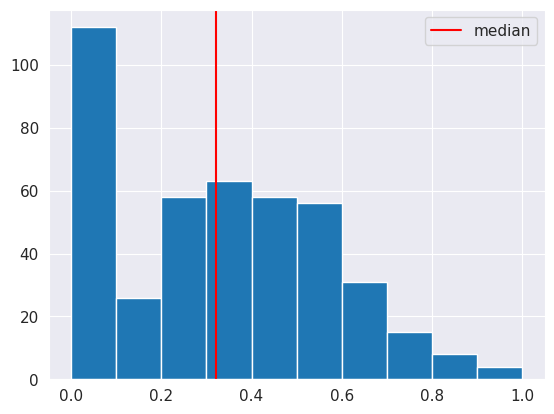

In [36]:
res = {}
for video_path in vids:
    try:
        pose_df = ap.load(Path(video_path), only_load=True)
    except MissingFile:
        continue
    q = pose_df.notna().sum() / len(pose_df)
    res[video_path] = q[('left_ear', 'x')]

plt.hist(res.values())
plt.axvline(np.median(list(res.values())), c='r', label='median')
plt.legend()
plt.show()

In [39]:
import shutil

for video_path, q in res.items():
    p = Path(video_path)
    if q < 0.2 and 'test' not in video_path and p.exists():
        shutil.copyfile(video_path, f'/data/Pogona_Pursuit/output/models/train/videos/{p.name}')

In [108]:
def calc_head_angle(row):
    x_nose, y_nose = row.nose.cam_x, row.nose.cam_y
    x_ears = (row.right_ear.cam_x + row.left_ear.cam_x) / 2
    y_ears = (row.right_ear.cam_y + row.left_ear.cam_y) / 2
    dy = y_ears - y_nose
    dx = x_ears - x_nose
    if dx != 0.0:
        theta = np.arctan(abs(dy) / abs(dx))
    else:
        theta = np.pi / 2
    if dx > 0:  # looking south
        theta = np.pi - theta
    if dy < 0:  # looking opposite the screen
        theta = -1 * theta
    if theta < 0:
        theta = 2 * np.pi + theta
    return math.degrees(theta)

In [109]:
res = {}
with orm.session() as s:
    for exp in s.query(Experiment).filter_by(animal_id='PV91').all():
        for blk in exp.blocks:
            if blk.movement_type != 'rect_tunnel':
                continue

            vids = [v for v in blk.videos if v.cam_name == 'front']
            if not vids or len(vids) > 1:
                continue
            vid = vids[0]

            trajs = []
            for tr in blk.trials:
                if tr.bug_trajectory:
                    trajs.extend(tr.bug_trajectory)
            if trajs:
                bug_traj = pd.DataFrame(trajs)
                bug_traj['time'] = pd.to_datetime(bug_traj.time).dt.tz_localize(None) #.dt.tz_convert('Asia/Jerusalem')
                bug_traj = bug_traj.sort_values('time').rename(columns={'x': 'bug_x', 'y': 'bug_y'})

                pose_df = ap.load(Path(vid.path))
                if pose_df is None:
                    continue
                pose_df['angle'] = pose_df.apply(calc_head_angle, axis=1)
                pose_df['time'] = pd.to_datetime(pose_df.time, unit='s')
                pose_df = pd.DataFrame(pose_df).reset_index().rename(columns={'index': 'frame_id'})
                pose_df.columns = ['_'.join(c) if c[1] != '' else c[0] for c in pose_df.columns]

                pose_df = pd.merge_asof(left=pose_df, right=bug_traj, left_on='time', right_on='time', direction='nearest', tolerance=pd.Timedelta('1 second'))
                res[vid.id] = pose_df

# del vids, trajs
res.keys()

dict_keys([990, 935, 940, 945, 949, 996, 1001, 1006, 1012, 1019, 1023, 1029, 1034, 1039, 1044, 1048, 1065, 1071, 1077, 1082, 1087, 1092, 1097, 1102, 1107, 1112, 1117, 1122])

In [ ]:
res[990]

In [120]:
for vid_id, df in res.items():
    print(f'{vid_id} - {df.angle.notna().sum()}/{len(df)}')

990 - 0/10524
935 - 1285/10638
940 - 1455/10657
945 - 122/10656
949 - 0/10569
996 - 0/10447
1001 - 1528/10434
1006 - 0/17326
1012 - 0/17363
1019 - 4677/16879
1023 - 4314/16789
1029 - 5112/17515
1034 - 5106/17071
1039 - 2249/17484
1044 - 5295/17298
1048 - 2299/14267
1065 - 0/17349
1071 - 4646/17275
1077 - 6618/17071
1082 - 3082/16774
1087 - 5822/17093
1092 - 4860/17412
1097 - 6835/16917
1102 - 7934/17135
1107 - 3280/17296
1112 - 5935/17245
1117 - 0/17356
1122 - 0/17405


In [117]:
with orm.session() as s:
    vid = s.query(Video).filter_by(id=990).first()
    print(vid.path)

/data/Pogona_Pursuit/output/experiments/PV91/20230611/block6/videos/front_20230611T143011.mp4


In [127]:
video_path = '/data/Pogona_Pursuit/output/experiments/PV91/20230612/block3/videos/front_20230612T103014.mp4'
# video_path = '/data/Pogona_Pursuit/output/experiments/PV91/20230612/block4/videos/front_20230612T113014.mp4'
pose_df = ap.load(Path(video_path))
pose_df

left_ear                           mid_ears                        \
             cam_x       cam_y      prob        cam_x       cam_y      prob   
0       851.923706  328.037292  0.999557   818.300781  339.549561  0.999632   
1       852.227417  328.365204  0.999549   818.786987  339.426331  0.999679   
2       852.177795  328.356720  0.999624   818.393311  339.614563  0.999707   
3       852.461914  328.461304  0.999604   818.491150  339.737854  0.999701   
4       852.222412  328.252075  0.999660   818.365356  339.627930  0.999729   
...            ...         ...       ...          ...         ...       ...   
17510  1043.498413  431.795502  0.999707  1019.932678  407.360046  0.998442   
17511  1043.499023  431.795227  0.999707  1019.926636  407.367035  0.998431   
17512  1043.500977  431.796906  0.999705  1019.940369  407.366119  0.998438   
17513  1043.506104  431.821777  0.999711  1019.952576  407.365631  0.998416   
17514  1043.528198  431.848145  0.999700  1019.999756  407.380005  0.998347   

             nose                         right_ear  ...        vy        ax  \
            cam_x       cam_y      prob       cam_x  ...                       
0      868.277466  389.881042  0.999993  784.677795  ...  0.276169 -0.000073   
1      868.152832  390.194611  0.999992  785.346497  ...  0.427558 -0.000252   
2      867.949341  390.530121  0.999991  784.608887  ...  0.558224 -0.000344   
3      867.937744  390.512177  0.999991  784.520386  ...  0.666527 -0.000511   
4      867.937012  390.531860  0.999991  784.508301  ...  0.755298 -0.000550   
...           ...         ...       ...         ...  ...       ...       ...   
17510  966.685425  438.649536  0.999851  996.366943  ...  0.108196  0.058175   
17511  966.662048  438.671173  0.999849  996.354187  ...  0.107553  0.057131   
17512  966.684753  438.614349  0.999859  996.379761  ...  0.106578  0.055557   
17513  966.694092  438.627045  0.999852  996.399048  ...  0.105353  0.053643   
17514  966.596069  438.464691  0.999853  996.471252  ...  0.103436  0.050881   

             ay       nose              left_ear             right_ear  \
                         x          y          x          y          x   
0      0.002301  -3.739066  14.791394  39.382606  13.997687   1.534180   
1      0.005853  -3.731205  14.768944  39.361976  13.971462   1.492001   
2      0.010418  -3.718369  14.744923  39.365347  13.972141   1.538527   
3      0.015438  -3.717637  14.746207  39.346048  13.963777   1.544109   
4      0.020581  -3.717591  14.744798  39.362316  13.980510   1.544872   
...         ...        ...        ...        ...        ...        ...   
17510  0.066670  40.616898   8.562826  38.528954  12.604380  38.651111   
17511  0.065685  40.618446   8.561243  38.528913  12.604399  38.651956   
17512  0.064525  40.616942   8.565400  38.528780  12.604283  38.650263   
17513  0.063235  40.616324   8.564472  38.528431  12.602563  38.648985   
17514  0.061568  40.622816   8.576350  38.526930  12.600740  38.644203   

                     angle  
               y            
0      17.570674  2.356194  
1      17.611796  2.356194  
2      17.584238  2.356194  
3      17.574069  2.356194  
4      17.574827  2.356194  
...          ...       ...  
17510  12.639710  2.356194  
17511  12.638670  2.356194  
17512  12.638927  2.356194  
17513  12.640818  2.356194  
17514  12.640641  2.356194  

[17515 rows x 26 columns]

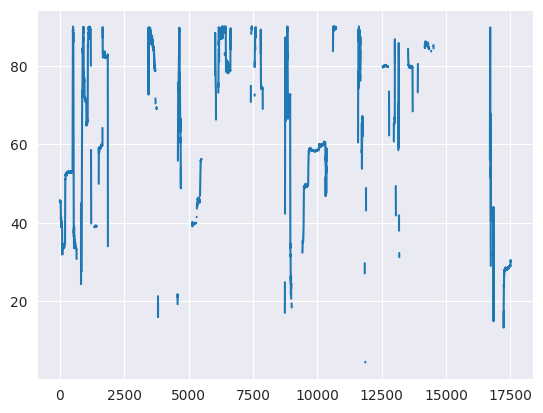

In [128]:
pose_df['angle_new'] = pose_df.apply(calc_head_angle, axis=1)
plt.plot(pose_df.angle_new)

In [110]:
bodyparts = ['nose', 'right_ear', 'left_ear']
threshold = 0.8
COLORS = list(TABLEAU_COLORS.values()) + list(CSS4_COLORS.values())


def plot_single_part(df, frame_id, frame):
    if np.isnan(df['x'][frame_id]):
        return frame
    cX = round(df['x'][frame_id])
    cY = round(df['y'][frame_id])
    color = tuple(int(COLORS[1][j:j + 2], 16) for j in (1, 3, 5))
    cv2.circle(frame, (cX, cY), 7, color, -1)
    return frame


def plot_predictions(frame, frame_id, df, parts2plot=None):
    """scatter the body parts prediction dots"""
    x_legend, y_legend = 30, 30
    parts2plot = parts2plot or bodyparts
    if frame_id not in df.index:
        return
    for i, part in enumerate(df.columns.get_level_values(0).unique()):
        if not part or (parts2plot and part not in parts2plot):
            continue
        elif df[part].loc[frame_id].isnull().values.any(): # or df[part]['prob'].loc[frame_id] < threshold:
            continue

        cX = round(df[part]['cam_x'][frame_id])
        cY = round(df[part]['cam_y'][frame_id])
        color = tuple(int(COLORS[i][j:j + 2], 16) for j in (1, 3, 5))
        cv2.circle(frame, (cX, cY), 8, color, -1)
        cv2.circle(frame, (x_legend, y_legend), 5, color, -1)
        put_text(part, frame, x_legend + 20, y_legend)
        y_legend += 30
    return frame

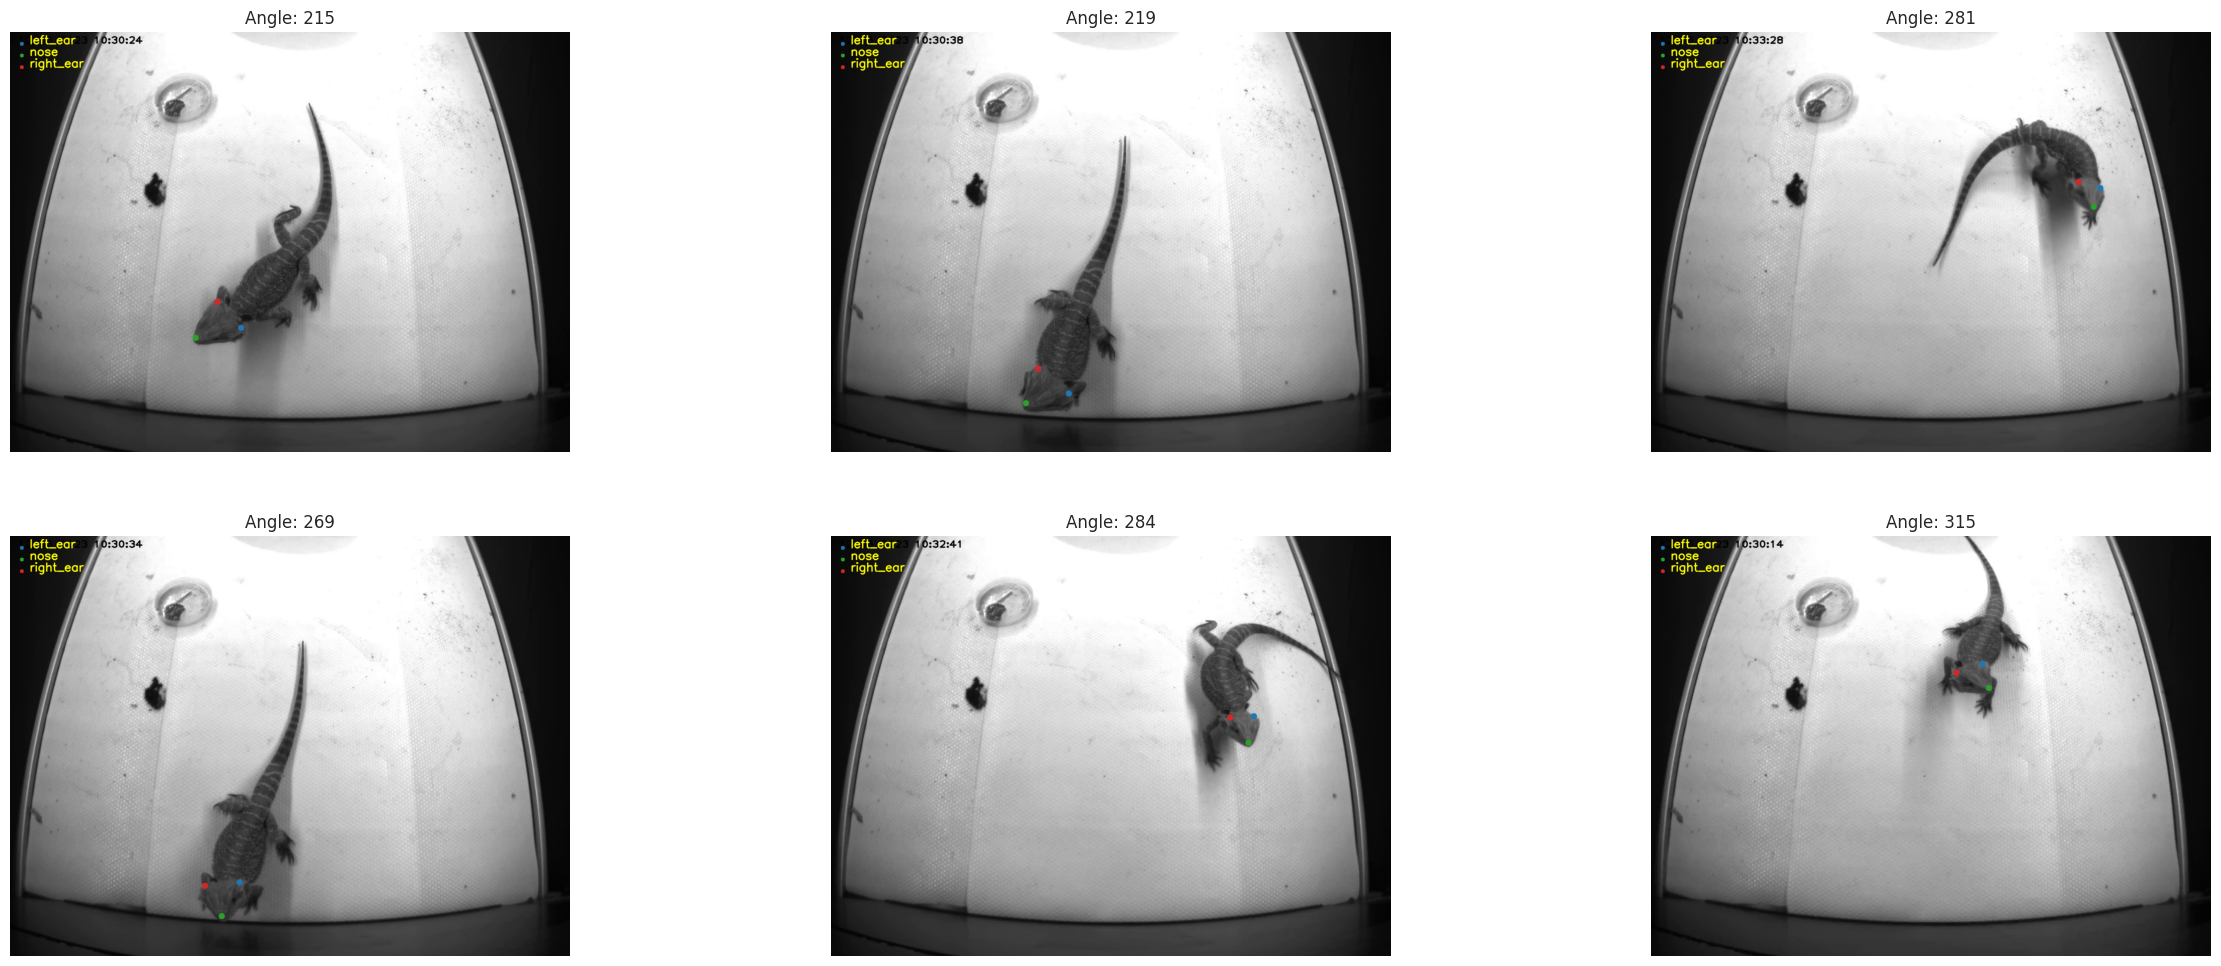

In [131]:
frames2plot = [600, 1400, 11593, 1200, 8786, 0]
cols = 3
rows = int(np.ceil(len(frames2plot)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(30, 6*rows))
axes = axes.flatten()
cap = cv2.VideoCapture('/data/Pogona_Pursuit/output/experiments/PV91/20230612/block3/videos/front_20230612T103014.mp4')
for i, frame_id in enumerate(frames2plot):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    frame = plot_predictions(frame, frame_id, pose_df)
    axes[i].imshow(frame, cmap='gray')
    angle = calc_head_angle(pose_df.loc[frame_id])
    axes[i].set_title(f'Angle: {angle:.0f}')
    axes[i].grid(False)
    axes[i].axis('off')
    # cap.release()

In [137]:
columns = [('left_ear', 'cam_x'), ('left_ear', 'cam_y'), ('nose', 'cam_x'), ('nose', 'cam_y'), ('right_ear', 'cam_x'), ('right_ear', 'cam_y'), ('expected', '')]
xf = pd.DataFrame([[2, 4, 4, 2, 6, 4, 90], [2, 2, 4, 4, 2, 6, 0]], columns=columns)
xf.columns = pd.MultiIndex.from_tuples(columns)
calc_head_angle(xf.loc[1])

0.0

In [113]:
ids = pose_df.index[pose_df[[('nose', 'x'), ('left_ear', 'x'), ('right_ear', 'x')]].notna().all(axis=1)].tolist()
[i for i in ids if i > 10800]

[11581,
 11582,
 11583,
 11584,
 11585,
 11586,
 11587,
 11588,
 11589,
 11590,
 11591,
 11592,
 11593,
 11594,
 11595,
 11596,
 11597,
 11598,
 11599,
 11600,
 11601,
 11602,
 11603,
 11604,
 11605,
 11606,
 11607,
 11608,
 11609,
 11610,
 11611,
 11612,
 11613,
 11614,
 11615,
 11616,
 11617,
 11618,
 11619,
 11620,
 11621,
 11622,
 11623,
 11624,
 11625,
 11626,
 11627,
 11628,
 11629,
 11630,
 11631,
 11632,
 11633,
 11634,
 11635,
 11636,
 11637,
 11638,
 11639,
 11640,
 11641,
 11642,
 11643,
 11644,
 11645,
 11646,
 11647,
 11648,
 11649,
 11650,
 11651,
 11652,
 11653,
 11654,
 11655,
 11656,
 11657,
 11658,
 11659,
 11660,
 11661,
 11662,
 11663,
 11664,
 11665,
 11666,
 11667,
 11668,
 11670,
 11671,
 11672,
 11675,
 11678,
 11680,
 11723,
 11724,
 11725,
 11726,
 11727,
 11728,
 11729,
 11730,
 11731,
 11732,
 11733,
 11734,
 11735,
 11736,
 11737,
 11738,
 11739,
 11740,
 11741,
 11742,
 11743,
 11744,
 11745,
 11746,
 11747,
 11748,
 11749,
 11750,
 11751,
 11752,
 11753,


In [3]:
exp_dir = '../output/experiments/PV80'
videos = list(Path(exp_dir).rglob('*.mp4')) + list(Path(exp_dir).rglob('*.avi'))
videos = [v for v in videos if 'front' in v.name and ap.get_predicted_cache_path(v).exists()]
videos = sorted(videos, key=lambda x: x.stem.split('_')[1])
# videos

In [4]:
video_path = videos[-1]
pred_df = ap.load_predicted_video(video_path)

In [24]:
video_path

PosixPath('../output/experiments/PV80/20230221/block13/videos/front_20230221T181523.mp4')

In [90]:
video_path = Path('/data/Pogona_Pursuit/output/experiments/PV80/20230221/block13/videos/front_20230221T181523.mp4')
ap = DLCArenaPose('front', is_commit_db=False)
pred_df = ap.load_predicted(video_path)
pred_df

2023-02-25 00:09:39 - calibration-pose-estimator - INFO - MainProcess - Loaded 186 markers from ../output/calibrations/markers_front_null.pkl


left_ear                              nose                        \
            cam_x       cam_y      prob       cam_x       cam_y      prob   
0      754.301453   -0.151189  0.000126  762.878540   -5.285370  0.000248   
1      754.205872   -0.077392  0.000118  762.751343   -5.292593  0.000229   
2      754.097229   -0.162373  0.000123  762.748413   -5.305212  0.000239   
3      754.245789   -0.232433  0.000111  762.747559   -5.406330  0.000225   
4      754.048828   -0.082616  0.000123  762.763611   -5.333169  0.000237   
...           ...         ...       ...         ...         ...       ...   
15947  852.345825  774.577942  0.997236  865.511047  865.838440  0.989070   
15948  852.171997  774.674500  0.997213  865.580444  865.856079  0.989635   
15949  852.287354  774.537964  0.997325  865.593262  865.672241  0.989573   
15950  852.335693  774.713745  0.997149  865.695984  865.767639  0.989965   
15951  852.356384  774.647400  0.997211  865.715881  865.658142  0.989569   

        right_ear                                             time   left_ear  \
            cam_x       cam_y      prob                                     x   
0      760.184448   -0.076023  0.000167 2023-02-21 18:15:23.467934  18.103197   
1      760.135498   -0.119037  0.000156 2023-02-21 18:15:23.484599  18.119028   
2      760.140137   -0.122532  0.000165 2023-02-21 18:15:23.501264  18.154997   
3      760.176392   -0.216072  0.000157 2023-02-21 18:15:23.517928  18.102013   
4      760.036499   -0.064612  0.000165 2023-02-21 18:15:23.534593  18.161525   
...           ...         ...       ...                        ...        ...   
15947  789.940002  808.662842  0.997803 2023-02-21 18:19:49.220340  13.158098   
15948  790.197632  808.706055  0.997745 2023-02-21 18:19:49.237005  13.188246   
15949  790.161804  808.402161  0.997757 2023-02-21 18:19:49.253670  13.164406   
15950  790.244202  808.608826  0.997777 2023-02-21 18:19:49.270334  13.158944   
15951  790.250854  808.520874  0.997805 2023-02-21 18:19:49.286999  13.158311   

                       nose                          right_ear             \
               y          x          y is_in_screen          x          y   
0      79.981331  16.682617  81.682029         -1.0  17.128826  79.956433   
1      79.956886  16.703684  81.684421         -1.0  17.136933  79.970681   
2      80.013158  16.704654  81.692777         -1.0  17.135397  79.972995   
3      80.033093  16.704565  81.745814         -1.0  17.125900  80.023861   
4      79.936920  16.700091  81.691615         -1.0  17.166217  79.929190   
...          ...        ...        ...          ...        ...        ...   
15947   8.865371  12.172174   4.096511         -1.0  17.749795   7.268050   
15948   8.844760  12.157950   4.092617         -1.0  17.697478   7.271214   
15949   8.869222  12.157275   4.122030         -1.0  17.709561   7.324774   
15950   8.835694  12.142009   4.100099         -1.0  17.696997   7.282768   
15951   8.851719  12.143075   4.118451         -1.0  17.699469   7.300872   

          angle  
                 
0      4.213514  
1      4.219440  
2      4.206971  
3      4.225393  
4      4.211043  
...         ...  
15947  2.261548  
15948  2.262616  
15949  2.260650  
15950  2.263547  
15951  2.263684  

[15952 rows x 18 columns]

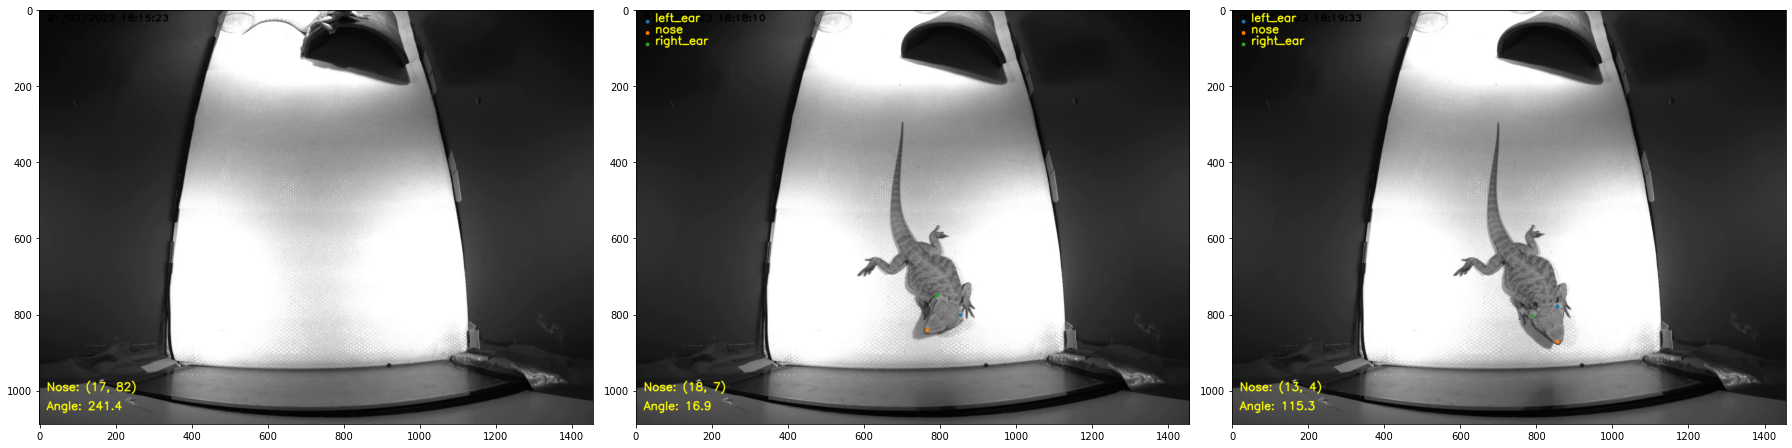

In [92]:
import math
from Arena.analysis.predictors.deeplabcut import PredPlotter

cap = cv2.VideoCapture(video_path.resolve().as_posix())
frames2plot = [0, 10000, 15000]
fig, axes = plt.subplots(1, len(frames2plot), figsize=(25, 10))
for i, frame_id in enumerate(frames2plot):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    frame = PredPlotter.plot_predictions(frame, frame_id, pred_df)
    angle = math.degrees(pred_df.loc[frame_id, ("angle")])
    x, y = pred_df.loc[frame_id, ("nose", ['x', 'y'])]
    frame = PredPlotter.put_text(f'Nose: {(round(x), round(y))}', frame, 20, 1000)
    frame = PredPlotter.put_text(f'Angle: {angle:.1f}', frame, 20, 1050)
    axes[i].imshow(frame)
fig.tight_layout()

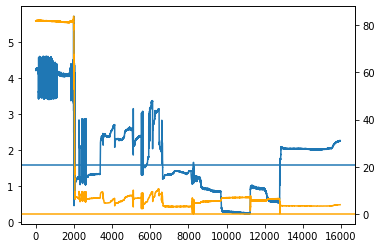

In [94]:
ax1 = plt.subplot()
pred_df['angle'].plot(ax=ax1)
ax1.axhline(np.pi/2)
ax2 = plt.twinx()
pred_df[('nose', 'y')].plot(ax=ax2, color='orange')
ax2.axhline(0, color='orange')

<AxesSubplot:xlabel='x', ylabel='y'>

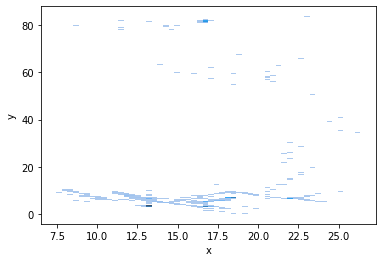

In [52]:
sns.histplot(data=pred_df['nose'], x='x', y='y')

In [149]:
type(pred_df['nose']) is pd.DataFrame

True

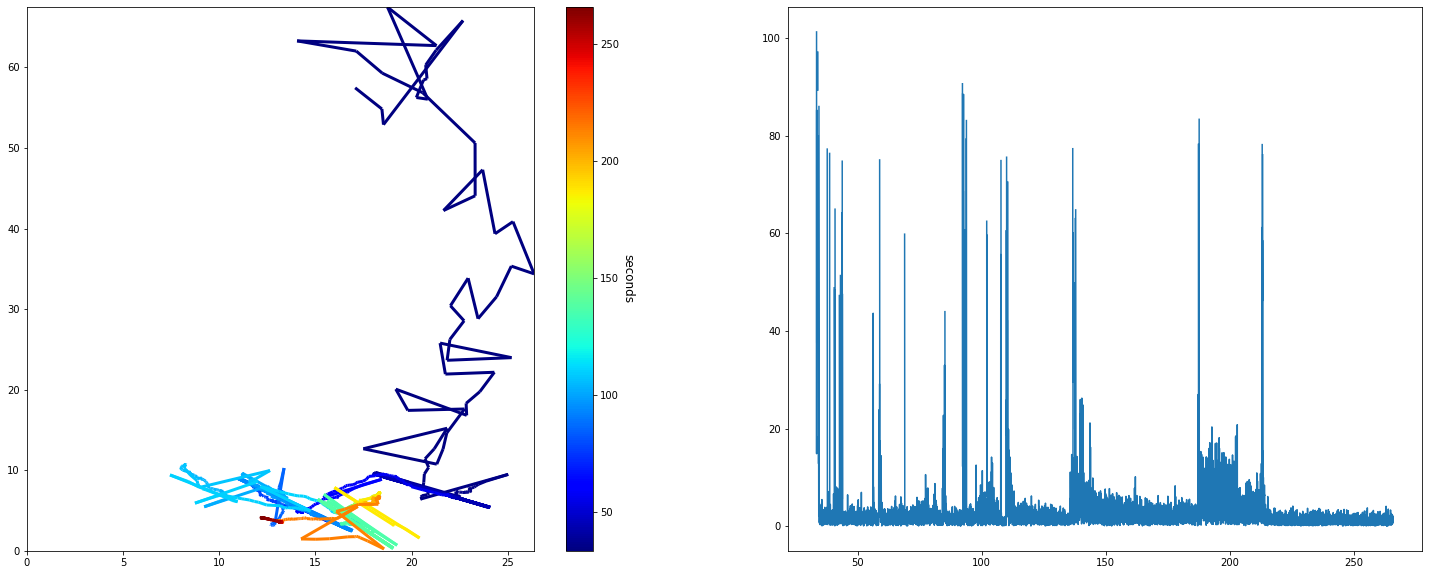

In [128]:
fig, axes = plt.subplots(1,2, figsize=(25, 10))
df = pred_df.nose.query('prob>0.7')
t = (pred_df.loc[df.index, 'time'] - pred_df['time'].iloc[0]).dt.total_seconds()
lc = colorline(axes[0], df.x, df.y, z=t, norm=None)
cbar = fig.colorbar(lc, ax=axes[0])
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('seconds', rotation=270, fontsize=12)

v = np.sqrt(df.x.diff()**2 + df.y.diff()**2)
v = remove_outliers(v.fillna(0), thresh=3, is_replace_nan=True)
v = v / t.diff()
axes[1].plot(t, v)

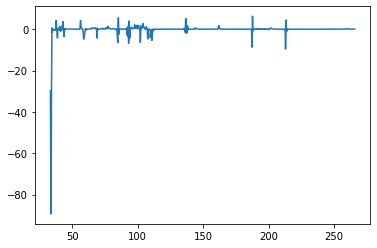

In [140]:
from scipy.signal import savgol_filter

def calc_derivative(x, y=None, dt=0.016, window_length=41, deriv=0):
    dx = savgol_filter(x, window_length=window_length, polyorder=2, deriv=deriv, delta=dt)
    if y is not None:
        dy = savgol_filter(y, window_length=window_length, polyorder=2, deriv=deriv, delta=dt)
        return np.insert(dx, 0, np.nan), np.insert(dy, 0, np.nan)
    else:
        return np.insert(dx, 0, np.nan)


# v = np.sqrt((np.vstack(calc_derivative(df.x, df.y, deriv=1)) ** 2).sum(axis=0))
v = calc_derivative(df.y, deriv=1)
plt.plot(t, v[1:])

2001     0.000000
2002          NaN
2003          NaN
2004          NaN
2005          NaN
           ...   
15947    0.158652
15948    0.071604
15949    0.184284
15950    0.140188
15951    0.111290
Length: 13951, dtype: float32

In [125]:
v

2001           NaN
2002     11.369472
2003      7.777082
2004      8.161995
2005      4.354556
           ...    
15947     0.158652
15948     0.071604
15949     0.184284
15950     0.140188
15951     0.111290
Length: 13951, dtype: float32

In [21]:
%matplotlib inline
from IPython.display import display, Image, clear_output
import ipywidgets

cap = cv2.VideoCapture(video_path.resolve().as_posix())
display_handle=display(None, display_id=True)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
image_widget = ipywidgets.Image(format='jpeg')
try:
    for i in range(n_frames):
        clear_output(wait=True)
        ret, frame = cap.read()
        frame = cv2.resize(frame, None, fx=0.25, fy=0.25)
        # _, frame = cv2.imencode('.jpeg', frame)
        image_widget.value =cv2.imencode('.jpeg', frame)[1].tobytes()
        # display_handle.update(Image(data=frame.tobytes()))
        display(image_widget)
except KeyboardInterrupt:
    pass
finally:
    cap.release()
    display_handle.update(None)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [17]:
video_path.resolve().as_posix()

'/data/Pogona_Pursuit/output/experiments/PV80/20230221/block13/videos/front_20230221T181523.mp4'

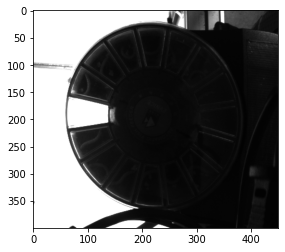

In [154]:
frame = cv2.imread('/data/Pogona_Pursuit/output/captures/20230225T145814_feeder.png')
x, y, w, h = (1000, 200, 450, 400)
plt.imshow(frame[y:y+h, x:x+w])

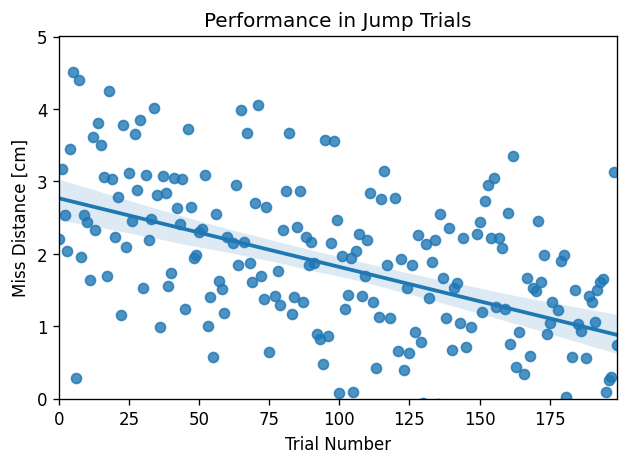

In [172]:
t = np.arange(200)
miss = 3*np.exp(-t/200) + np.random.normal(0,1,len(t))
plt.figure(dpi=120)
sns.regplot(x=t, y=miss)
plt.ylim([0, max(miss) + 0.5])
plt.ylabel('Miss Distance [cm]')
plt.xlabel('Trial Number')
plt.title('Performance in Jump Trials')
plt.show()

In [173]:
import pickle

with open('../output/jump_performance.pkl', 'wb') as f:
    pickle.dump({'miss': miss, 't': t}, f)

In [162]:
ph = PogonaHead('top')
ph.init(None)
for p in Path('/data/Pogona_Pursuit/output/datasets/cutler/top_camera/train').glob('*.jpg'):
    img = cv2.imread(p.as_posix())
    det, pred_img = ph.predict(img, is_draw_pred=True)
    if det is None:
        print(f'No det found for: {p}')
        continue
    else:
        plt.figure()
        plt.imshow(pred_img)

No det found for: /data/Pogona_Pursuit/output/datasets/cutler/top_camera/train/top_20230609T093021_17703.jpg
No det found for: /data/Pogona_Pursuit/output/datasets/cutler/top_camera/train/top_20230609T150023_0.jpg
No det found for: /data/Pogona_Pursuit/output/datasets/cutler/top_camera/train/top_20230609T140022_1561.jpg
No det found for: /data/Pogona_Pursuit/output/datasets/cutler/top_camera/train/top_20230609T100021_15621.jpg
No det found for: /data/Pogona_Pursuit/output/datasets/cutler/top_camera/train/top_20230609T143023_0.jpg
No det found for: /data/Pogona_Pursuit/output/datasets/cutler/top_camera/train/top_20230609T090021_0.jpg
No det found for: /data/Pogona_Pursuit/output/datasets/cutler/top_camera/train/top_20230609T140022_2500.jpg
No det found for: /data/Pogona_Pursuit/output/datasets/cutler/top_camera/train/top_20230609T150023_3745.jpg
No det found for: /data/Pogona_Pursuit/output/datasets/cutler/top_camera/train/top_20230609T153023_7412.jpg
No det found for: /data/Pogona_Purs

In [163]:
det

array([     115.96,      321.05,      151.81,      353.07,     0.80616], dtype=float32)